
PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: 1.5265542699663794
Average annual returns: 14.496722334170729%
Total returns: 144.79464331391952%
Max drawdown: -20.917597058487193%
Stressed period return during Covid19:  -13.609529615513896%
Stressed period return during Dec18:  3.5765779786037366%
Stressed period return during Fall2015:  2.147954666945533%
Stressed period return during Oct14:  0.4763952234596674%
Stressed period return during Aug2013:  -0.11368183480925491%


PERFORMANCE STATISTICS FOR SECTOR NEUTRAL
Daily annualized sharpe: 1.7791742805753734
Average annual returns: 15.226439863974802%
Total returns: 152.08313149851023%
Max drawdown: -15.52335198506758%
Stressed period return during Covid19:  -11.462535953198696%
Stressed period return during Dec18:  3.3098623037572614%
Stressed period return during Fall2015:  1.8041572233077257%
Stressed period return during Oct14:  1.0406147335733473%
Stressed period return during Aug2013:  -0.10501250844735996%

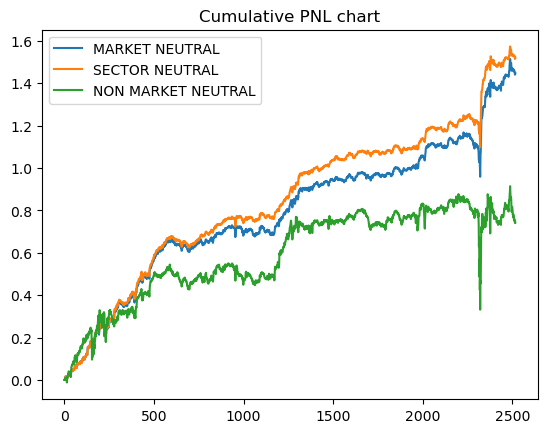

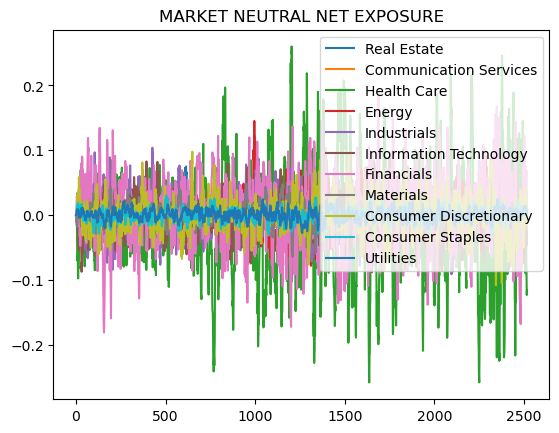

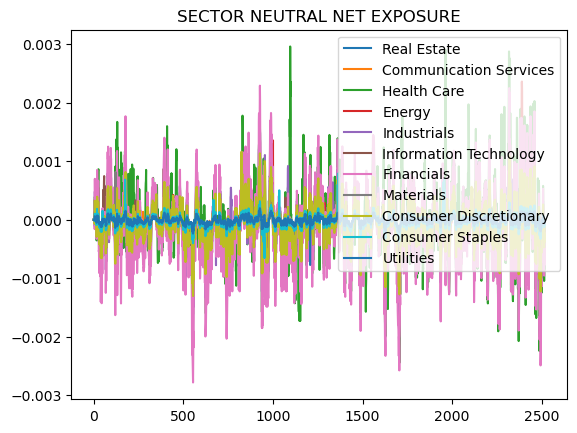

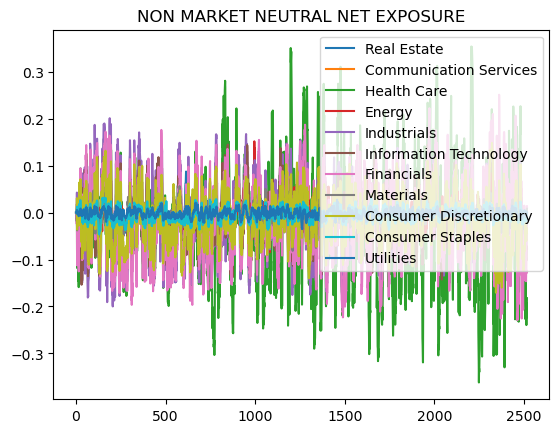

In [1]:
#GENERAL INSTRUCTIONS:
#1.  LINES 4 to 150 ARE OLD SCRIPT FROM CLASS 1


import pandas as pd;
import numpy as np;
import os;
import matplotlib.pyplot as plt;

os.chdir("c:\\SMU")  #CHANGE THIS LINE 

#Utility method takes in daily % pnl vector and computes portfolio diagnostics
#daily % pnl is inputed as a dataframe, with date as index and corresponding pnl for that date as the value
def portfolioDiagnostics(signal_df, label):
    #NET SECTOR EXPOSURES
    plt.figure();
    sector_df = pd.read_csv("sector.csv", on_bad_lines='skip')
    d = sector_df.set_index('ticker').to_dict()
    signal_df2 = signal_df.copy(deep=True)
    signal_df2.columns = signal_df2.columns.to_series().map(d['sector'])
    uniquesector = list(set(signal_df2.columns))
    for tsector in uniquesector:
        if (str(tsector)=='nan'):
            continue;
        tmean = signal_df2.loc[:, tsector].sum(axis=1)
        tmean[~np.isfinite(tmean)] = 0
        plt.plot(tmean.values, label=tsector)
        plt.legend();
        plt.title(label+" NET EXPOSURE")
    plt.show(block=False)
    return


#Utility method takes in daily % pnl vector and computes pnl diagnostics
#daily % pnl is inputed as a dataframe, with date as index and corresponding pnl for that date as the value
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    import matplotlib.pyplot as plt
    import numpy as np
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label);
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    plt.plot(cumpnl.values, label = label);
    plt.legend();
    plt.title("Cumulative PNL chart")
    #HERE, we compute performance during 'stressed' historical periods
    stressedmarkets = dict()
    stressedmarkets["Covid19"] = (20200301, 20200317);          #Market crash 1H March 2020
    stressedmarkets["Dec18"] = (20181215, 20181231);            #Market crash last 2 weeks
    stressedmarkets["Fall2015"] = (20150701, 20150901);         #Taper tantrum / EU debt crisis.  24 Aug 2015 was "BlackMonday" for Asian, EU and US markets
    stressedmarkets["Oct14"] = (20141001, 20141031);            #Treasury flash crash on 15 Oct 2014
    stressedmarkets["Aug2013"] = (20130820, 20130825);          #Flash freeze on 22 Aug 2013

    for tkey in stressedmarkets.keys():
        mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
        print("Stressed period return during "+tkey+":  "+str(pnl[mask].sum()*100)+"%")
    print("===========================")
    print("")


#=======ACTUAL STRATEGY SCRIPT STARTS HERE============================#

russell_df = pd.read_csv("russell2000pvdata.csv", on_bad_lines='skip')
vars = ['open', 'high', 'low', 'close', 'volume']
rawdata = {}
reversiontimehorizon = 10           #NUMBER OF TRADING DAYS TO COMPUTE MEAN REVERSION OVER.  THIS IS A PARAMETER FOR FITTING
universesize = 2000                 #SIZE OF PORTFOLIO IN NUMBER OF STOCKS.  IF THIS IS MORE THAN 2000, IT WILL GENERALLY JUST BE CAPPED AT 2000 SINCE BASE UNIVERSE IS RUSSELL 2000
maxindividualweight = 0.01          #MAXIMUM FRACTION A SINGLE POSITION CAN TAKE UP OF ENTIRE PORTFOLIO.  0.01 MEANS 1%.  i.e. if you have a portfolio of $100 million, max single position size is $1 million

#MARKET NEUTRAL STRATEGY BASED ON N DAY REVERSION, BASE UNIVERSE IS STOCKS IN RUSSELL 2000
for tvar in vars:
    rawdata[tvar] = russell_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdata[tvar] = rawdata[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
    rawdata[tvar] = rawdata[tvar].iloc[:, :universesize]

return_df = (rawdata['close'] / rawdata['close'].shift(1)) - 1
signal_df = -return_df.rolling(reversiontimehorizon, min_periods = 3).mean()
signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
signal_df = signal_df.shift(1)                                              #TO AVOID FORWARD BIAS.  WE USE YESTERDAY'S INFORMATION TO EXECUTE AT TODAY'S CLOSE PRICES
for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_df.shift(-1)                                    #BASED ON YESTERDAY'S INFORMATION, WE EXECUTE AT TODAY'S CLOSE PRICES AND COMPUTE OUR PNL BASED ON TOMORROW'S RETURN
pnl = pnl_df.sum(axis=1)
pnlPerformance(pnl, "MARKET NEUTRAL")
marketneutralportfolio = signal_df.copy(deep=True)


#SECTOR NEUTRAL STRATEGY BASED ON N DAY REVERSION, ALL STOCKS IN RUSSELL 2000
sector_df = pd.read_csv("sector.csv", on_bad_lines='skip')
d = sector_df.set_index('ticker').to_dict()
signal_df2 = signal_df.copy(deep=True)                                      #WE JUST REUSE THE PORTFOLIO WEIGHTS FROM PREVIOUS STRATEGY, SINCE WE ARE JUST NEUTRALIZING DIFFERENTLY HERE
signal_df2.columns = signal_df2.columns.to_series().map(d['sector'])
uniquesector = list(set(signal_df2.columns))
for tsector in uniquesector:
    if (str(tsector)=='nan'):
        continue;
    tmean = signal_df2.loc[:, tsector].mean(axis=1)
    tmean[~np.isfinite(tmean)] = 0
    signal_df2.loc[:, tsector] = signal_df2.loc[:, tsector].subtract(tmean, axis='index');
signal_df = pd.DataFrame(data = signal_df2.values, index = signal_df.index, columns = signal_df.columns)
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_df.shift(-1)
pnl = pnl_df.sum(axis=1)
reversionsectorneutral = pnl.copy(deep=True)
pnlPerformance(pnl, "SECTOR NEUTRAL")
sectorneutralportfolio = signal_df.copy(deep=True)


#NON MARKET NEUTRAL STRATEGY BASED ON N DAY REVERSION, BASE UNIVERSE IS STOCKS IN RUSSELL 2000
for tvar in vars:
    rawdata[tvar] = russell_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdata[tvar] = rawdata[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
    rawdata[tvar] = rawdata[tvar].iloc[:, :universesize]

return_df = (rawdata['close'] / rawdata['close'].shift(1)) - 1
signal_df = -return_df.rolling(reversiontimehorizon, min_periods = 3).mean()
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
signal_df = signal_df.shift(1)

for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_df.shift(-1)
pnl = pnl_df.sum(axis=1)
pnlPerformance(pnl, "NON MARKET NEUTRAL")
nonmarketneutralportfolio = signal_df.copy(deep=True)
plt.show(block = False)
portfolioDiagnostics(marketneutralportfolio, "MARKET NEUTRAL");
portfolioDiagnostics(sectorneutralportfolio, "SECTOR NEUTRAL");
portfolioDiagnostics(nonmarketneutralportfolio, "NON MARKET NEUTRAL");




PERFORMANCE STATISTICS FOR PTG MARKET NEUTRAL
Daily annualized sharpe: 1.030002039534619
Average annual returns: 7.296051115658851%
Total returns: 80.45923035879345%
Max drawdown: -23.046380484700297%
Stressed period return during Covid19:  -19.999442607502715%
Stressed period return during Dec18:  1.4580473191959136%
Stressed period return during Fall2015:  -0.8617716499599168%
Stressed period return during Oct14:  -0.16480362249277375%
Stressed period return during Aug2013:  0.18915582749218568%

AVERAGE DAILY TURNOVER NO DECAY: 0.1921897679467675

PERFORMANCE STATISTICS FOR PTG MARKET NEUTRAL NO TRADING COSTS
Daily annualized sharpe: 1.030002039534619
Average annual returns: 7.296051115658851%
Total returns: 80.45923035879345%
Max drawdown: -23.046380484700297%
Stressed period return during Covid19:  -19.999442607502715%
Stressed period return during Dec18:  1.4580473191959136%
Stressed period return during Fall2015:  -0.8617716499599168%
Stressed period return during Oct14:  -0.16

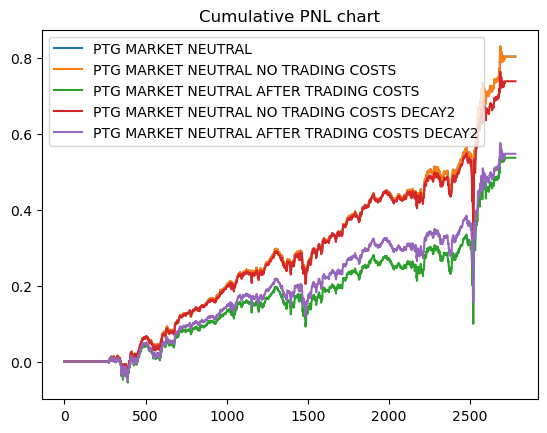

In [2]:

#PTG SCRIPT.  YOU NEED TO UNZIP ADDITIONAL CSV FILE FROM "PRICETARGETS.ZIP" INTO SAME DIRECTORY
russell1000_df = pd.read_csv("russell1000pvdata.csv", on_bad_lines='skip')
vars = ['open', 'high', 'low', 'close', 'volume']
rawdata_r1000 = {}
universesize = 1000                 #SIZE OF PORTFOLIO IN NUMBER OF STOCKS.  IF THIS IS MORE THAN 2000, IT WILL GENERALLY JUST BE CAPPED AT 2000 SINCE BASE UNIVERSE IS RUSSELL 2000
maxindividualweight = 0.01          #MAXIMUM FRACTION A SINGLE POSITION CAN TAKE UP OF ENTIRE PORTFOLIO.  0.01 MEANS 1%.  i.e. if you have a portfolio of $100 million, max single position size is $1 million

#MARKET NEUTRAL STRATEGY BASED ON N DAY REVERSION, BASE UNIVERSE IS STOCKS IN RUSSELL 2000
for tvar in vars:
    rawdata_r1000[tvar] = russell1000_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdata_r1000[tvar] = rawdata_r1000[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
    rawdata_r1000[tvar] = rawdata_r1000[tvar].iloc[:, :universesize]

return_r1000_df = (rawdata_r1000['close'] / rawdata_r1000['close'].shift(1)) - 1

ptg = pd.read_csv("russell1000ptg.csv", on_bad_lines='skip')
ptgvars = ptg.columns[3:]
rawdataptg = {}
for tvar in ptgvars:
    rawdataptg[tvar] = ptg.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdataptg[tvar] = rawdataptg[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
    rawdataptg[tvar] = rawdataptg[tvar].iloc[:, :universesize]

ptgforecast = rawdataptg['PTGmean']/(rawdata_r1000['close'])
ptgforecast = 2*ptgforecast - ptgforecast.shift(10)                                                                        #THIS IS EQUIVALENT TO SORTING ON E(PRICE APPRECIATION) + DELTA(E(PRICE APPRECIATION), BOTH OF WHICH ARE MOMENTUM SIGNALS
ptgforecast = ptgforecast.fillna(method='ffill', limit = 66)
signal_df = ptgforecast.subtract(ptgforecast.mean(axis=1), axis='index')
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
signal_df = signal_df.shift(1)
for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_r1000_df.shift(-1)
pnl = pnl_df.sum(axis=1)
ptgmarketneutralpnl = pnl.copy(deep=True)
pnlPerformance(pnl, "PTG MARKET NEUTRAL")

#HERE, WE INCORPORATE TRANSACTIONS COSTS IN OUR SAME STRATEGY FROM ABOVE
bpspertrade = 5
pertradecost = bpspertrade/10000                                                                                            #ASSUME 5 BPS PER TRADE = bid-ask spread + commissions + exchange fees + market impact.  FOR RUSSELL 1000, THIS FIGURE IS PROBABLY "MOSTLY" CORRECT ON AVERAGE AS OF MID 2021 ASSUMING (BULGE BRACKET PRIME BROKER OR AT LEAST INTERACTIVE BROKERS) AND MODEST AUM (SAY USD100M)
turnover_df = (signal_df - signal_df.shift(1).fillna(0)).abs().fillna(0)
totaltradecosts = turnover_df*pertradecost
dailytradecosts = totaltradecosts.sum(axis=1)
pnl_aftercost = pnl - dailytradecosts
print ("AVERAGE DAILY TURNOVER NO DECAY: "+str(turnover_df.sum(axis=1).mean()))                                             #HOW MUCH WE ACTIVELY TRADE EACH STOCK EVERYDAY, AS % OF PORTFOLIO GMV
pnlPerformance(pnl, "PTG MARKET NEUTRAL NO TRADING COSTS")
pnlPerformance(pnl_aftercost, "PTG MARKET NEUTRAL AFTER TRADING COSTS")

#OPTIMIZING AFTER COST PERFORMANCE
decay = 2
signal_df_decay = signal_df.rolling(decay).mean();                                                                          #SPREAD OUR TRADES EVENLY OVER N DAYS.   FOR ILLUSTRATIVE PURPOSES ONLY.  IN PRACTICE, YOU MAY WISH TO ASSIGN A HEAVIER WEIGHT TO MORE RECENT TARGET PORTFOLIO RATHER THAN JUST SPREAD EVENLY
turnover_df_decay = (signal_df_decay - signal_df_decay.shift(1).fillna(0)).abs().fillna(0)
totaltradecosts_decay = turnover_df_decay * pertradecost
dailytradecosts_decay = totaltradecosts_decay.sum(axis=1)
pnl_beforecost_decay = (signal_df_decay * return_r1000_df.shift(-1)).sum(axis=1)
pnl_aftercost_decay = pnl_beforecost_decay - dailytradecosts_decay
print ("AVERAGE DAILY TURNOVER DECAY"+str(decay)+": "+str(turnover_df_decay.sum(axis=1).mean()))                            #HOW MUCH WE ACTIVELY TRADE EACH STOCK EVERYDAY, AS % OF PORTFOLIO GMV
pnlPerformance(pnl_beforecost_decay, "PTG MARKET NEUTRAL NO TRADING COSTS DECAY"+str(decay))
pnlPerformance(pnl_aftercost_decay, "PTG MARKET NEUTRAL AFTER TRADING COSTS DECAY"+str(decay))
plt.show(block = False)
